In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import string
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bert import SwitchLayer,BertTransformer,BertEmbedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
train= pd.read_csv("train.tsv",delimiter='\t',header=None)
test=pd.read_csv("test.tsv",delimiter='\t',header=None)
valid=pd.read_csv("val.tsv",delimiter='\t',header=None)


def convert(dataframe):
    dataframe[1]=dataframe[1].map({'false':0,'true':1,'barely-true':0,'pants-fire':0,'half-true':1,'mostly-true':1})
    return dataframe

train=convert(train)
valid=convert(valid)
test=convert(test)

In [3]:
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,1,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,0,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


1    5752
0    4488
Name: 1, dtype: int64


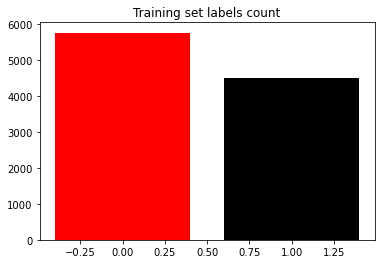

In [4]:
print(train[1].value_counts())


plt.title('Training set labels count')
plt.bar(train[1].unique(),train[1].value_counts(),color=['red','black'])
plt.show()

health-care
0    198
1    183
Name: 1, dtype: int64


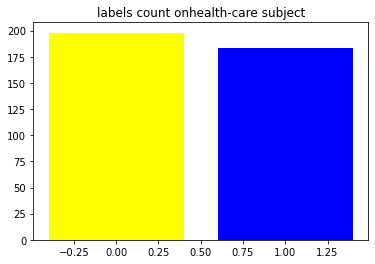

economy,jobs
1    88
0    37
Name: 1, dtype: int64


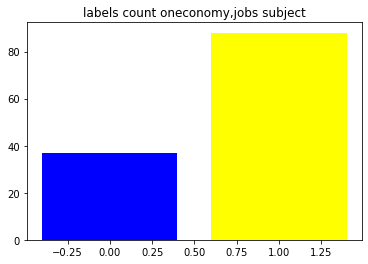

education
1    160
0     77
Name: 1, dtype: int64


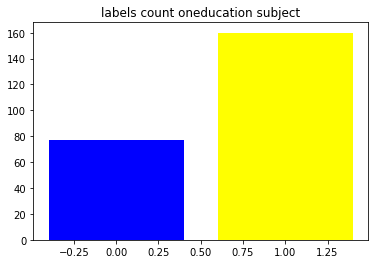

candidates-biography
0    98
1    92
Name: 1, dtype: int64


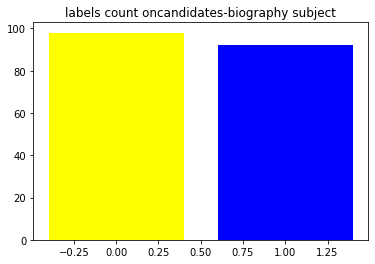

elections
1    138
0    114
Name: 1, dtype: int64


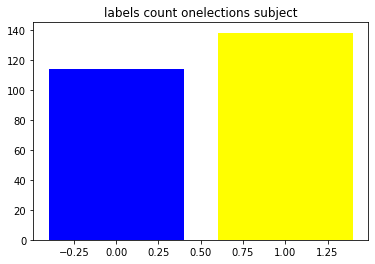

federal-budget
1    82
0    39
Name: 1, dtype: int64


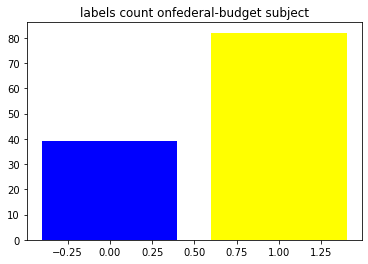

economy
1    86
0    51
Name: 1, dtype: int64


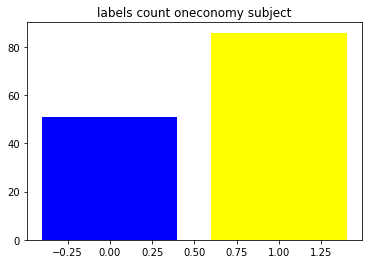

immigration
1    133
0    120
Name: 1, dtype: int64


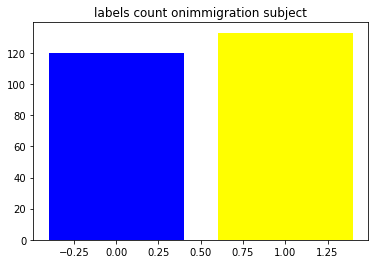

taxes
1    184
0    124
Name: 1, dtype: int64


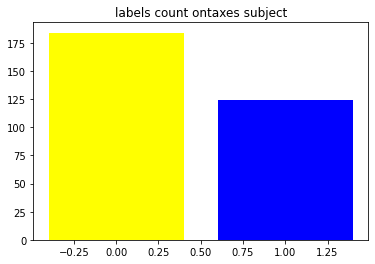

guns
1    83
0    47
Name: 1, dtype: int64


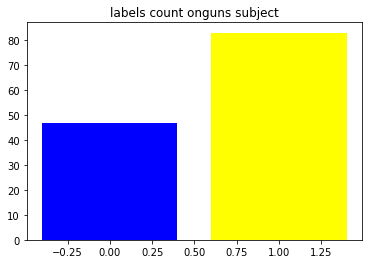

In [5]:
def sub(df,sub,value):
    p=df[df[value]==sub]
    plt.title('labels count on'+sub+' subject')
    plt.bar(p[1].unique(),p[1].value_counts(),color=['yellow','blue'])
    plt.show()

for i in train[3].unique():
    subject=train[train[3]==i]
    if subject[1].value_counts().sum()>=100:
        print(i)
        print(subject[1].value_counts())
        sub(train,i,3)

In [6]:
def cloud(dataf):
    word = ''
    sw = set(STOPWORDS)
    for wd in dataf[2]:
        wd = str(wd)
        tokens = wd.split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        word += " ".join(tokens)+" "
    wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(word)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud)
    plt.axis("off")

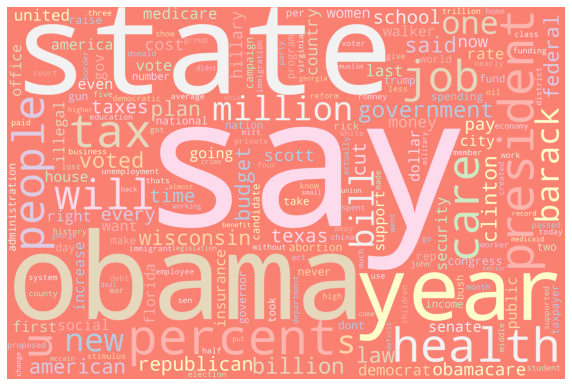

In [7]:
dataf=train[train[1]==0]
cloud(dataf)

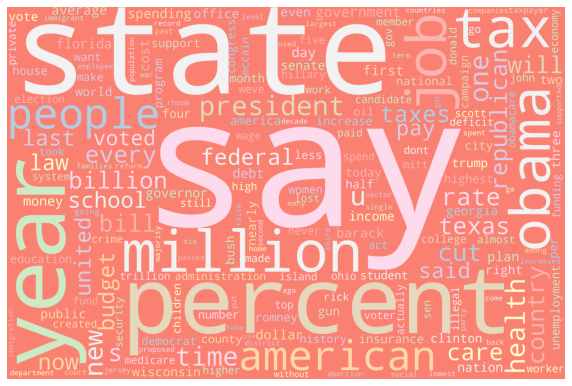

In [8]:
dataf=train[train[1]==1]
cloud(dataf)

In [9]:
y_train=train.iloc[:,1].values
x_train=train.iloc[:,2].values

y_test=test.iloc[:,1].values
x_test=test.iloc[:,2].values

y_valid=valid.iloc[:,1].values
x_valid=valid.iloc[:,2].values

Number of titles: 10240
Max length of the titles: 467
Mean length of the titles: 18.01005859375


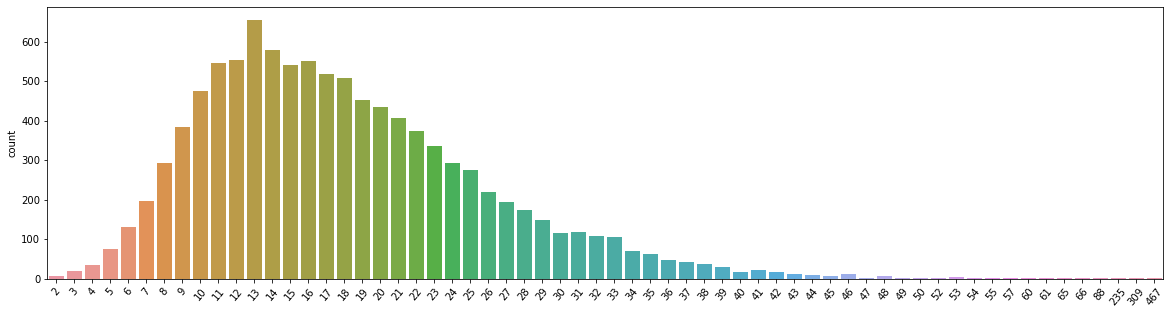

In [10]:
import seaborn as sns
max_len = 0
titles_len = []
for title in x_train:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

print('Number of titles:', len(x_train))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))
plt.figure(figsize=(20,5))
g = sns.countplot(x=titles_len)
g.set_xticklabels(g.get_xticklabels(), rotation=50)
plt.show()

In [11]:
def reduce(data,y):
    data1=[]
    ydata=[]
    for i in range(len(data)):
        if len(data[i].split())<30:
            data1.append(data[i])
            ydata.append(y[i])
    return np.asarray(data1),np.asarray(ydata)

In [12]:
x_train,y_train=reduce(x_train,y_train)
x_valid,y_valid=reduce(x_valid,y_valid)
x_test,y_test=reduce(x_test,y_test)

Number of titles: 9377
Max length of the titles: 29
Mean length of the titles: 16.35213821051509


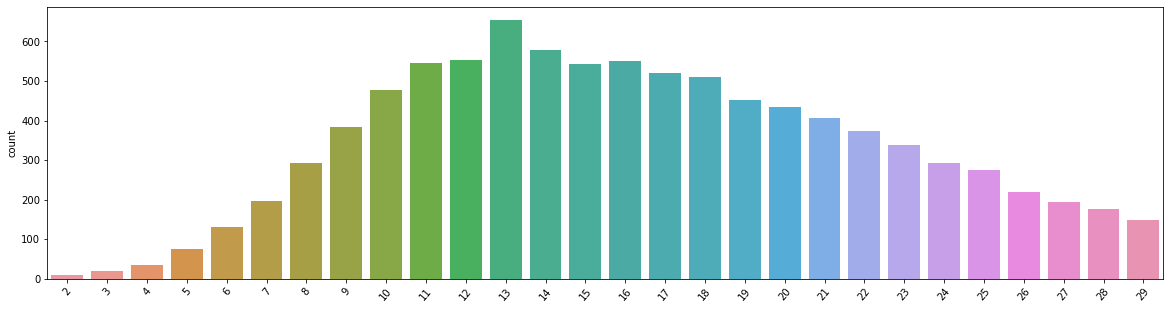

In [13]:
import seaborn as sns
max_len = 0
titles_len = []
for title in x_train:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

print('Number of titles:', len(x_train))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))
plt.figure(figsize=(20,5))
g = sns.countplot(x=titles_len)
g.set_xticklabels(g.get_xticklabels(), rotation=50)
plt.show()

In [14]:
tk = Tokenizer(oov_token="<UNK>",lower=True,filters='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
tk.fit_on_texts(x_train)

seq = tk.texts_to_sequences(x_train)
pad_train = pad_sequences(seq, padding='post')

seq_test = tk.texts_to_sequences(x_valid)
pad_valid = pad_sequences(seq_test, padding='post')

seq_valid = tk.texts_to_sequences(x_test)
pad_test = pad_sequences(seq_valid, padding='post')

In [15]:
word_index = tk.word_index
print(word_index)

{'<UNK>': 1, 'the': 2, 'in': 3, 'of': 4, 'to': 5, 'a': 6, 'says': 7, 'and': 8, 'for': 9, 'is': 10, 'that': 11, 'on': 12, 'has': 13, 'have': 14, 'percent': 15, 'are': 16, 'than': 17, 'more': 18, 'we': 19, 'was': 20, 'state': 21, 'by': 22, 'obama': 23, '000': 24, 's': 25, 'from': 26, 'tax': 27, 'as': 28, 'with': 29, 'it': 30, 'our': 31, 'not': 32, 'health': 33, 'president': 34, 'people': 35, 'years': 36, 'year': 37, 'he': 38, 'states': 39, 'million': 40, 'care': 41, 'at': 42, 'i': 43, 'an': 44, 'his': 45, 'would': 46, 'jobs': 47, 'one': 48, 'u': 49, 'be': 50, 'been': 51, 'over': 52, 'their': 53, 'will': 54, 'new': 55, 'were': 56, 'this': 57, '1': 58, 'about': 59, 'you': 60, 'texas': 61, 'who': 62, 'when': 63, 'billion': 64, 'or': 65, 'bill': 66, 'taxes': 67, 'every': 68, 'all': 69, 'barack': 70, 'only': 71, 'they': 72, 'voted': 73, 'under': 74, 'there': 75, 'since': 76, 'said': 77, 'no': 78, 'out': 79, 'federal': 80, 'country': 81, 'government': 82, 'now': 83, 'budget': 84, 'up': 85, 'ha

In [16]:
print(seq[:5])

[[7, 2, 6281, 1194, 579, 591, 341, 418, 4590, 512, 12, 1576], [63, 189, 2, 1979, 4, 989, 830, 30, 619, 63, 1131, 301, 161, 252, 11, 619, 5, 2173, 3, 34, 321, 561, 1311, 175], [117, 96, 3712, 29, 167, 216, 22, 311, 5, 342, 321, 153, 2, 1029, 4, 2, 3144, 12, 369], [33, 41, 278, 273, 10, 674, 5, 675, 433, 411, 405, 4591], [2, 332, 4592, 619, 42, 2, 441, 4, 180, 550]]


In [17]:
print(pad_train[:5])

[[   7    2 6281 1194  579  591  341  418 4590  512   12 1576    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [  63  189    2 1979    4  989  830   30  619   63 1131  301  161  252
    11  619    5 2173    3   34  321  561 1311  175    0    0    0    0
     0    0    0    0    0    0    0]
 [ 117   96 3712   29  167  216   22  311    5  342  321  153    2 1029
     4    2 3144   12  369    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [  33   41  278  273   10  674    5  675  433  411  405 4591    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   2  332 4592  619   42    2  441    4  180  550    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]


In [18]:
from bert import SwitchLayer,BertTransformer,BertEmbedding
from tensorflow.keras.layers import Input as inputlayer
from tensorflow.keras.layers import Dense as Feed_forward_layer
from tensorflow.keras.layers import GlobalAveragePooling1D as GlobalAveragePoolinglayer

In [19]:
def create_transformer():
    switch = SwitchLayer(15, 16, 100)
    tf_block = BertTransformer(dim_embed=16,num=3,node=16,attention='self-additive')
    
    inputs = layers.Input(shape=(None,))
    em_layr = BertEmbedding(maxlen=32, vocab_size=10000,embed_dim= 16)
    hidden_layer = em_layr(inputs)
    hidden_layer = tf_block(hidden_layer)
    hidden_layer = GlobalAveragePoolinglayer()(hidden_layer)
    hidden_layer = Feed_forward_layer(16, activation="relu")(hidden_layer)
    outputs = Feed_forward_layer(2, activation="softmax")(hidden_layer)
    classifier = keras.Model(inputs=inputs, outputs=outputs)
    return classifier

In [20]:
def run_model(tf_model):
    tf_model.compile(
        optimizer=keras.optimizers.Adam(0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = tf_model.fit(
        pad_train,
        y_train,
        batch_size=64,
        epochs=25,
        validation_data=(pad_valid, y_valid),
    )
    return history

tf_model = create_transformer()
hist=run_model(tf_model)

Epoch 1/25
147/147 [==============================] - 5s 18ms/step - loss: 0.6812 - accuracy: 0.5589 - val_loss: 0.6704 - val_accuracy: 0.5894
Epoch 2/25
147/147 [==============================] - 2s 15ms/step - loss: 0.6339 - accuracy: 0.6346 - val_loss: 0.5563 - val_accuracy: 0.7423
Epoch 3/25
147/147 [==============================] - 2s 15ms/step - loss: 0.5444 - accuracy: 0.7242 - val_loss: 0.4357 - val_accuracy: 0.8199
Epoch 4/25
147/147 [==============================] - 2s 14ms/step - loss: 0.4542 - accuracy: 0.7864 - val_loss: 0.3418 - val_accuracy: 0.8748
Epoch 5/25
147/147 [==============================] - 2s 15ms/step - loss: 0.3780 - accuracy: 0.8356 - val_loss: 0.2704 - val_accuracy: 0.9039
Epoch 6/25
147/147 [==============================] - 2s 14ms/step - loss: 0.3322 - accuracy: 0.8551 - val_loss: 0.2589 - val_accuracy: 0.8942
Epoch 7/25
147/147 [==============================] - 2s 15ms/step - loss: 0.2819 - accuracy: 0.8847 - val_loss: 0.1823 - val_accuracy: 0.9372

In [21]:
tf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 bert_embedding (BertEmbeddi  (None, None, 16)         160512    
 ng)                                                             
                                                                 
 bert_transformer (BertTrans  (None, None, 16)         3840      
 former)                                                         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_33 (Dense)            (None, 16)                272       
                                                             

In [22]:
tf_model.evaluate(pad_test,y_test)

59/59 [==============================] - 1s 6ms/step - loss: 0.0148 - accuracy: 0.9947


[0.01484667882323265, 0.9946751594543457]

In [23]:
tf_model.evaluate(pad_train,y_train)

294/294 [==============================] - 2s 6ms/step - loss: 0.0137 - accuracy: 0.9952


[0.013729048892855644, 0.995201051235199]

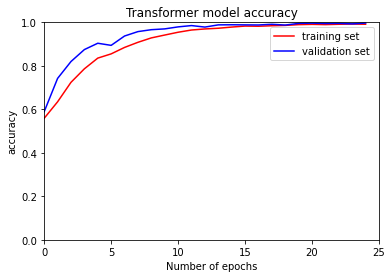

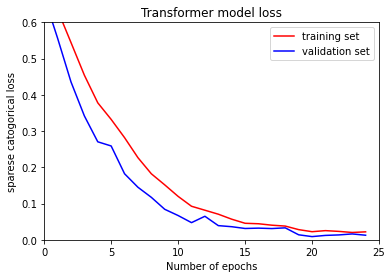

In [24]:
def plots(x,y,title,x_label,y_label,xlimit,ylimit=[0,2]):
    plt.plot(x,color='red')
    plt.plot(y,color='blue')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xlim(xlimit[0],xlimit[1])
    plt.ylim(ylimit[0],ylimit[1])
    plt.legend(['training set', 'validation set'])
    plt.show()


plots(hist.history['accuracy'],hist.history['val_accuracy'],'Transformer model accuracy','Number of epochs','accuracy',[0,25],[0,1])
plots(hist.history['loss'],hist.history['val_loss'],'Transformer model loss','Number of epochs','sparese catogorical loss',[0,25],[0,0.6])